<a href="https://colab.research.google.com/github/Miranda-Merino-Irigoyen-Jorge-Missael/Piloto/blob/main/Proyecto_Ingenieria_Financiera.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparación del entorno.


In [21]:


# Instalar webdriver-manager si no está instalado
!pip install webdriver-manager selenium

# Importar librerías necesarias
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager

# Configurar opciones del navegador
options = Options()
options.add_argument("--headless")  # Sin interfaz gráfica
options.add_argument("--no-sandbox")
options.add_argument("--disable-dev-shm-usage")

# Descargar automáticamente la versión compatible de ChromeDriver
service = Service(ChromeDriverManager().install())

# Crear el navegador
driver = webdriver.Chrome(service=service, options=options)

# Probar conexión
driver.get("https://www.google.com")
print("Título de la página:", driver.title)

# Cerrar navegador
driver.quit()


Título de la página: Google


# Comparador de precios

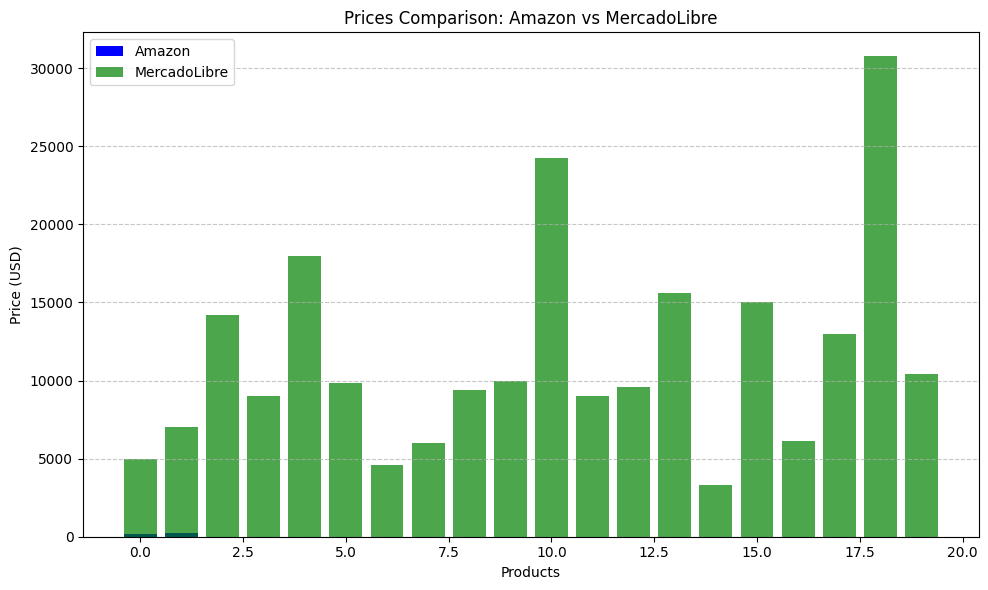

In [5]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
from openpyxl import Workbook
from openpyxl.styles import PatternFill, Border, Side, Alignment, Font
from openpyxl.utils.dataframe import dataframe_to_rows

# Scraping Amazon
api_key = "d5fc8be171b2e7e86724a89d7e05f8da"
amazon_url = f"https://www.amazon.com/s?k=laptop"
amazon_scraper_url = f"http://api.scraperapi.com?api_key={api_key}&url={amazon_url}"
amazon_response = requests.get(amazon_scraper_url)

if amazon_response.status_code == 200:
    amazon_soup = BeautifulSoup(amazon_response.text, 'html.parser')
    amazon_titles = amazon_soup.find_all('h2', class_='a-size-medium a-spacing-none a-color-base a-text-normal')
    amazon_prices = amazon_soup.find_all('span', class_='a-price')

    amazon_product_names = [title.text.strip() for title in amazon_titles]
    amazon_product_prices = [
        float(price.find('span', class_='a-offscreen').text.strip().replace('$', '').replace(',', ''))
        for price in amazon_prices if price.find('span', class_='a-offscreen')
    ]
    amazon_products = [{"Name": name, "Price": price} for name, price in zip(amazon_product_names, amazon_product_prices)][:20]
else:
    amazon_products = []

# Scraping MercadoLibre
mercadolibre_url = "https://listado.mercadolibre.com.mx/laptop"
mercadolibre_response = requests.get(mercadolibre_url)

if mercadolibre_response.status_code == 200:
    mercadolibre_soup = BeautifulSoup(mercadolibre_response.text, 'html.parser')
    mercadolibre_products = mercadolibre_soup.find_all('li', class_='ui-search-layout__item shops__layout-item', limit=20)

    mercadolibre_product_data = []
    for product in mercadolibre_products:
        name_tag = product.find('a', class_='poly-component__title')
        name = name_tag.text.strip() if name_tag else "Nombre no encontrado"

        price_tag = product.find('span', class_='andes-money-amount__fraction')
        price = float(price_tag.text.strip().replace(',', '')) if price_tag else None

        if name and price:
            mercadolibre_product_data.append({"Name": name, "Price": price})
else:
    mercadolibre_product_data = []

# Combine results into a DataFrame
data = pd.DataFrame(amazon_products + mercadolibre_product_data)
data['Platform'] = ['Amazon'] * len(amazon_products) + ['MercadoLibre'] * len(mercadolibre_product_data)

# Save to Excel with styling
wb = Workbook()
ws = wb.active
ws.title = "Tabla de precios"

header_fill = PatternFill(start_color="FFC000", end_color="FFC000", fill_type="solid")
amazon_fill = PatternFill(start_color="BDD7EE", end_color="BDD7EE", fill_type="solid")
mercadolibre_fill = PatternFill(start_color="C6E0B4", end_color="C6E0B4", fill_type="solid")
border_style = Border(
    left=Side(style="thin"),
    right=Side(style="thin"),
    top=Side(style="thin"),
    bottom=Side(style="thin")
)

for r_idx, row in enumerate(dataframe_to_rows(data, index=False, header=True), start=1):
    for c_idx, value in enumerate(row, start=1):
        cell = ws.cell(row=r_idx, column=c_idx, value=value)
        cell.alignment = Alignment(horizontal="center", vertical="center")
        cell.border = border_style

        if r_idx == 1:
            cell.fill = header_fill
            cell.font = Font(bold=True)
        elif data.iloc[r_idx - 2]['Platform'] == 'Amazon':
            cell.fill = amazon_fill
        else:
            cell.fill = mercadolibre_fill

wb.save("Tabla_Productos.xlsx")

# Create a bar plot
plt.figure(figsize=(10, 6))
amazon_prices = data[data['Platform'] == 'Amazon']['Price']
mercadolibre_prices = data[data['Platform'] == 'MercadoLibre']['Price']

plt.bar(range(len(amazon_prices)), amazon_prices, color='blue', label='Amazon')
plt.bar(range(len(mercadolibre_prices)), mercadolibre_prices, color='green', label='MercadoLibre', alpha=0.7)

plt.title("Prices Comparison: Amazon vs MercadoLibre")
plt.xlabel("Products")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show and save the plot
plt.savefig("price_comparison.png")
plt.show()
